# Functional alignment with the Shared Response Model (SRM)

This tutorial shows the basic application of the SRM to fMRI data. For more details, see the original [NIPS paper](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model.pdf) or these [tutorial slides](https://cameronphchen.github.io/files/20170215_SRM_Tutorial.pdf)

In [1]:
%matplotlib inline
import deepdish as dd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from scipy.stats import zscore, pearsonr
import numpy as np
import brainiak.funcalign.srm
from sklearn import decomposition

We will use data from the posterior cingulate cortex (PCC) of 17 subjects watching the first hour of [A Study in Pink](https://en.wikipedia.org/wiki/A_Study_in_Pink). Note that although in this case all subjects have the same number of voxels, that is not necessary for SRM.

In [2]:
loaded = dd.io.load('PCC.h5')
D = loaded['PCC']
coords = loaded['coords'].T
nSubj = D.shape[0]
T = D.shape[1]
nVox = D.shape[2]

subj_data = []
for k in range(nSubj):
    subj_data.append(D[k,:,:].T)

Fitting the SRM requires only two lines of code: creating the SRM instance, and then running the fit function. The fit function takes as input a list of VxT data matrices (one from each subject). It then computes (interally within the SRM instance) the weight matrices mapping each subject to the shared space.

In [3]:
srm = brainiak.funcalign.srm.SRM(features=50)
srm.fit(subj_data)

SRM(features=50, n_iter=10, rand_seed=0)

The learned matrices are voxel x feature maps from each subject's voxel space to the shared feature space. For example, we can visualize the first 3 feature maps for the first 2 subjects:

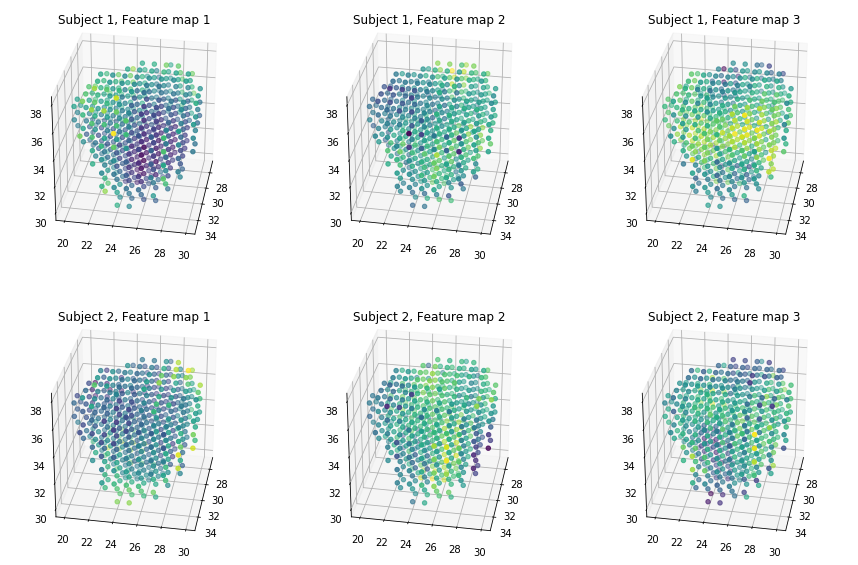

In [4]:
fig = plt.figure(figsize=(15,10))
for i in range(6):
    ax = fig.add_subplot(2,3,i+1, projection='3d')
    subj = np.floor(i/3).astype(int)
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=srm.w_[subj][:,round(i % 3)])
    ax.view_init(30,10)
    ax.set_title('Subject ' + str(subj+1) + ', Feature map ' + str((i%3)+1))

A common usage of SRM is to use some data to learn the shared space transform, and then apply this transform to held-out data and test some measure of alignment across subjects.

In [5]:
first_half = 1000
second_half = 970
subj_data_pt1 = [X[:,:first_half] for X in subj_data]
subj_data_pt2 = [X[:,first_half:(first_half+second_half)] for X in subj_data]

nSRMfeat = 50
srm = brainiak.funcalign.srm.SRM(features=nSRMfeat)
srm.fit(subj_data_pt1)  # fit on first 1000 timepoints

shared_space = srm.transform(subj_data_pt2) # apply learned transform to next 970 timepoints
shared_space = np.dstack([zscore(X, axis=1, ddof=1) for X in shared_space])  # z-score feature timecourses

For example, we can measure the pattern similarity of time segments across people. Here we divide the second half of the movie into 10-TR segments, and measure their similarity across participants using either the native (MNI-aligned) space or the SRM shared space.

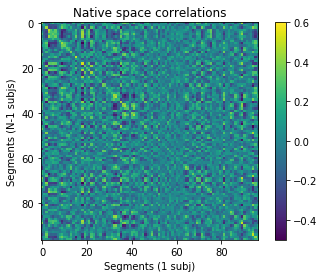

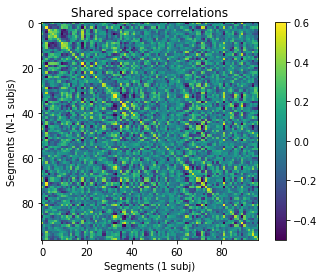

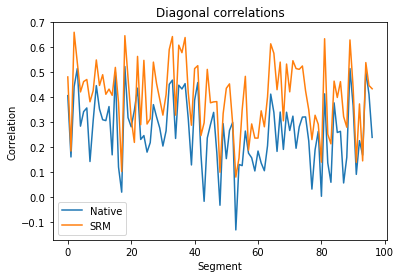

In [6]:
# compute average pattern within each time segment
win_size = 10
n_windows = round(second_half/win_size)
native_segment_patterns = np.zeros((n_windows, nSubj, nVox))
SRM_segment_patterns = np.zeros((n_windows, nSubj, nSRMfeat))
for w in range(n_windows):
    native_segment_patterns[w,:,:] = D[:,(first_half+w*win_size):(first_half+(w+1)*win_size),:].mean(1)
    SRM_segment_patterns[w,:,:] = shared_space[:,(w*win_size):((w+1)*win_size),:].mean(1).T

# compute across-subject pattern similarity for all pairs of time segments (leaving one subject out)
native_matchcorr = np.zeros((nSubj, n_windows))
SRM_matchcorr = np.zeros((nSubj, n_windows))
avg_native_segcorr = np.zeros((n_windows, n_windows))
avg_SRM_segcorr = np.zeros((n_windows, n_windows))
for loo in range(nSubj):
    native_group = native_segment_patterns[:,np.arange(nSubj) != loo, :].mean(1)
    SRM_group = SRM_segment_patterns[:,np.arange(nSubj) != loo, :].mean(1)
    
    native_segcorr = np.corrcoef(native_group, native_segment_patterns[:, loo, :])[:n_windows,n_windows:]
    SRM_segcorr = np.corrcoef(SRM_group, SRM_segment_patterns[:, loo, :])[:n_windows,n_windows:]
    
    native_matchcorr[loo,:] = np.diag(native_segcorr)
    SRM_matchcorr[loo,:] = np.diag(SRM_segcorr)
    
    avg_native_segcorr += native_segcorr/nSubj
    avg_SRM_segcorr += SRM_segcorr/nSubj

# plot results
plt.figure()
plt.imshow(avg_native_segcorr)
plt.title('Native space correlations')
plt.xlabel('Segments (1 subj)')
plt.ylabel('Segments (N-1 subjs)')
plt.colorbar()
plt.clim(-0.5, 0.6)

plt.figure()
plt.imshow(avg_SRM_segcorr)
plt.title('Shared space correlations')
plt.xlabel('Segments (1 subj)')
plt.ylabel('Segments (N-1 subjs)')
plt.colorbar()
plt.clim(-0.5, 0.6)

plt.figure()
plt.plot(native_matchcorr.mean(0))
plt.plot(SRM_matchcorr.mean(0))
plt.legend(['Native', 'SRM'])
plt.title('Diagonal correlations')
plt.xlabel('Segment')
plt.ylabel('Correlation')

How many feature maps do we need? One approach is to measure the fraction of variance in the held-out data captured by a given number of dimensions. In general a relatively small number of dimensions (an order of magnitude smaller than the number of voxels) captures the majority of the variance for typical ROIs.

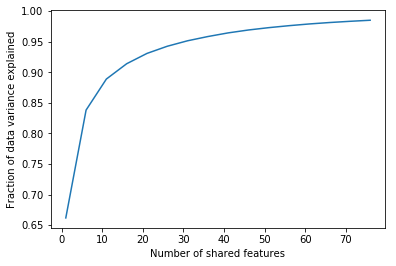

In [7]:
nFeat = np.arange(1,81,5)  # numbers of features to try
subj_var = [np.var(X) for X in subj_data]
var_exp = np.zeros(len(nFeat))
for f in range(len(nFeat)):
    srm = brainiak.funcalign.srm.SRM(features=nFeat[f])
    srm.fit(subj_data_pt1)
    shared_space = srm.transform(subj_data_pt2)
    
    # transform back to native space, then check reconstruction error
    reconstructed = [np.dot(srm.w_[k], shared_space[k]) for k in range(nSubj)]
    var_exp[f] = 1-np.mean([np.square(reconstructed[k]-subj_data_pt2[k]).mean()/subj_var[k] for k in range(nSubj)])

plt.plot(nFeat,var_exp)
plt.xlabel('Number of shared features')
plt.ylabel('Fraction of data variance explained')

How does using SRM compare to just applying PCA to the MNI-aligned voxels? First we can check the same measure of reconstruction error, using PCA instead of SRM. We find nearly identical results - that is, both PCA and SRM do a good job of capturing the variance in the data with a small number of dimensions.

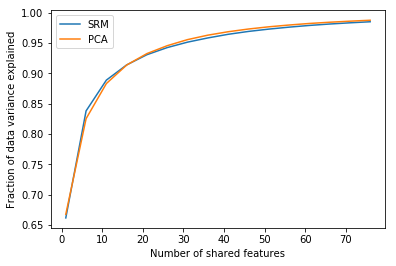

In [8]:
nFeat = np.arange(1,81,5)  # numbers of features to try
subj_var = [np.var(X) for X in subj_data]
pca_var_exp = np.zeros(len(nFeat))
for f in range(len(nFeat)):
    sk_pca = decomposition.PCA(n_components=nFeat[f])
    sk_pca.fit(np.column_stack(subj_data_pt1).T)
    
    # transform to PCA space and back, then check reconstruction error
    reconstructed = [sk_pca.inverse_transform(sk_pca.transform(X.T)).T for X in subj_data_pt2]
    pca_var_exp[f] = 1-np.mean([np.square(reconstructed[k]-subj_data_pt2[k]).mean()/subj_var[k] for k in range(nSubj)])
plt.plot(nFeat,var_exp)
plt.plot(nFeat,pca_var_exp)
plt.legend(['SRM','PCA'])
plt.xlabel('Number of shared features')
plt.ylabel('Fraction of data variance explained')

However, these methods look very different if we measure how well these features align across subjects. For example, we can measure the intersubject correlation between pairs of subjects for each of the feature dimensions (in the held-out data). We find that these are much higher in SRM, showing that these dimensions are much more appropriate for across-subject and group analyses.

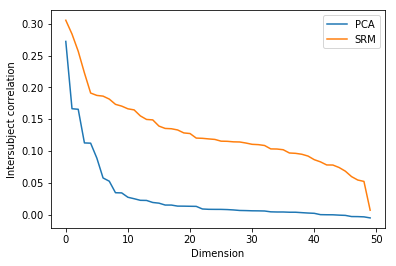

In [9]:
sk_pca = decomposition.PCA(n_components=nSRMfeat)
sk_pca.fit(np.column_stack(subj_data_pt1).T)
PCA_allsubj = sk_pca.transform(np.column_stack(subj_data_pt2).T)
PCA = [PCA_allsubj[t:(t+second_half),:].T for t in range(0,second_half*nSubj,second_half)]

srm = brainiak.funcalign.srm.SRM(features=nSRMfeat)
srm.fit(subj_data_pt1)  # fit on first 1000 timepoints
shared_space = np.dstack(srm.transform(subj_data_pt2)) # apply learned transform to next 970 timepoints

dimcorr = np.zeros((2,nSRMfeat))
for i in range(nSubj):
    for j in range(i+1,nSubj):
        for d in range(nSRMfeat):
            dimcorr[0,d] += pearsonr(PCA[i][d,:],PCA[j][d,:])[0]/((nSubj**2 - nSubj)/2)
            dimcorr[1,d] += pearsonr(shared_space[d,:,i],shared_space[d,:,j])[0]/((nSubj**2 - nSubj)/2)
plt.plot(np.flipud(np.sort(dimcorr[0,:])))
plt.plot(np.flipud(np.sort(dimcorr[1,:])))
plt.legend(['PCA', 'SRM'])
plt.xlabel('Dimension')
plt.ylabel('Intersubject correlation')